In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import norm
from scipy.stats import shapiro
import numpy as np
from matplotlib import colors as mcolors
import matplotlib.ticker as ticker


In [ ]:
class LinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 10)
    
    def forward(self, x):
        self.fc1data = self.fc1(x)
        self.relufc1data = F.relu(self.fc1data)
        self.fc2data = self.fc2(self.relufc1data)
        self.relufc2data = F.relu(self.fc2data)
        return self.fc2data       

net = LinearNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

First we check the accuracy of the trained model: see *Notebook1_training.ipynb*, *net_final.pth*.

In [ ]:
!git clone https://github.com/SimonGodskesen/NetworkProject

Cloning into 'NetworkProject'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 334 (delta 13), reused 83 (delta 7), pack-reused 232
Receiving objects: 100% (334/334), 150.00 MiB | 40.15 MiB/s, done.
Resolving deltas: 100% (19/19), done.


The following part until *Change in accuracy from removing nodes* is written by Catalina

In [ ]:
# contributor: Catalina: from here to Change in accuracy from removing nodes

# load model
PATH = "NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_final.pth"
net = LinearNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Load MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 5
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# accuracy of the network 
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(testloader,0):
        inputs, labels = data
        outputs = net(inputs.view(-1,28*28))
        for i,e in enumerate(outputs):
            if torch.argmax(e) == labels[i]:
                correct += 1
            total += 1
print(f"correct classification rate {correct/total}")


correct classification rate 0.9639


In [ ]:
# accuracy for each number
correct ={classname: 0 for classname in classes}
total = {classname:0 for classname in classes}

with torch.no_grad():
    for i, data in enumerate(testloader,0):
        inputs, labels = data
        outputs = net(inputs.view(-1,28*28))
        _, predictions = torch.max(outputs,1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct[classes[label]] +=1
            total[classes[label]]+=1

# print accuracy for each class
for classname, cor in correct.items():
    accuracy = cor/total[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:f}')
       
       

Accuracy for class: 0     is 0.985714
Accuracy for class: 1     is 0.981498
Accuracy for class: 2     is 0.963178
Accuracy for class: 3     is 0.950495
Accuracy for class: 4     is 0.957230
Accuracy for class: 5     is 0.959641
Accuracy for class: 6     is 0.971816
Accuracy for class: 7     is 0.961089
Accuracy for class: 8     is 0.963039
Accuracy for class: 9     is 0.943508


# Analysis of neurons strength for classification of each number

Here, we do the preprocessing steps for the neurons strength analysis for each input number image that is to be classified. We notice that different neurons are responsible for classifying specific numbers. 

In [ ]:
correct_pos_ns_allnum = []
wrong_pos_ns_allnum = []
# iterate through the numbers 0-10 and find out the number
# each input image is classified 
for number in range(10):
    allnumber = []
    for e in testset:
        if e[-1] == number:
            allnumber.append(e[0])
    allnumber2 = torch.Tensor(len(allnumber),28,28)
    allnumber = torch.cat(allnumber,out=allnumber2)
    with torch.no_grad():
        kk = net(allnumber.view(-1,28*28))

  # check which images classified correctly or incorrectly and save it for each number
    correctind = []
    wrongind = []
    for i,e in enumerate(kk):
        if torch.argmax(e) == number:
            correctind.append(i)
        else:
            wrongind.append(i)


    correctindtensor = torch.tensor(correctind,dtype=torch.long)
    wrongindtensor = torch.tensor(wrongind,dtype=torch.long)

    scaled_fc1data = torch.Tensor(len(net.fc1data),net.fc1data.size(dim=1))
    for i,e in enumerate(net.fc1data):
        for j,u in enumerate(e):
            scaled_fc1data[i][j] = u

    # for each number node data is saved in tensor for correct and incorrect classification
    fc1data_correct = scaled_fc1data[correctindtensor]
    fc1data_wrong = scaled_fc1data[wrongindtensor]
    
    # for each number a dictionary of all nodes in the hidden layer (200), with the neurons strength
    # is saved. 
    correct_pos_ns = {node_num: [] for node_num in range(200)}
    
    for corr_image_num in correctindtensor:
        for image in range(len(scaled_fc1data)):
            if corr_image_num == image:
                for i in range(len(scaled_fc1data[image])):
                    if scaled_fc1data[corr_image_num][i]>0: # positive node strength
                        correct_pos_ns[i].append(scaled_fc1data[image][i])
                        
    wrong_pos_ns = {node_num: [] for node_num in range(200)}
    for wrong_image_num in wrongindtensor:
        for image in range(len(scaled_fc1data)):
            if wrong_image_num == image:
                for i in range(len(scaled_fc1data[image])):
                    if scaled_fc1data[wrong_image_num][i]>0: # positive node strength
                        wrong_pos_ns[i].append(scaled_fc1data[image][i])

    # delete nodes negative node strength

    for key in list(correct_pos_ns.keys()):
        if correct_pos_ns[key] ==[]:
            del correct_pos_ns[key]

    for key in list(wrong_pos_ns.keys()):
        if wrong_pos_ns[key] ==[]:
            del wrong_pos_ns[key]
        

    # pos_ns_allnum is a list of 10 dictionaries, where each dictionary has all 
    # positive neurons strengths for each node in the hidden layer
    correct_pos_ns_allnum.append(correct_pos_ns)
    wrong_pos_ns_allnum.append(wrong_pos_ns)

In [ ]:
# count how many images activate each node
correct_pos_ns_allnum_count = correct_pos_ns_allnum
for number in correct_pos_ns_allnum_count:
    for key in number.keys():
        number[key] = len(number[key])


In [ ]:
# sort all neuron numbers by their value in the dictionary 
sorted_count = []
for number in correct_pos_ns_allnum_count:
    x = {k: v for k, v in sorted(number.items(), key=lambda item: item[1], reverse = True)}
    sorted_count.append(x)

In [ ]:
# show max 15 activated nodes
max_ns = []
for number in sorted_count:
    d = {}
    for key,value in list(number.items())[:15]:
        d[key] = value
    max_ns.append(d)

In [ ]:
i = 0
for nodes in max_ns:
    i +=1
    print(f'The nodes {nodes.keys()} are activated most when classifying the number {i}.' )

The nodes dict_keys([11, 37, 61, 71, 79, 113, 142, 90, 91, 99, 125, 160, 104, 181, 69]) are activated most when classifying the number 1.
The nodes dict_keys([6, 10, 19, 30, 38, 56, 62, 63, 64, 73, 79, 86, 89, 93, 98]) are activated most when classifying the number 2.
The nodes dict_keys([16, 79, 177, 142, 168, 38, 77, 96, 160, 150, 122, 37, 98, 178, 128]) are activated most when classifying the number 3.
The nodes dict_keys([37, 89, 142, 168, 178, 38, 66, 98, 175, 2, 79, 97, 122, 125, 156]) are activated most when classifying the number 4.
The nodes dict_keys([16, 18, 79, 142, 152, 160, 177, 178, 187, 189, 108, 122, 2, 80, 47]) are activated most when classifying the number 5.
The nodes dict_keys([38, 142, 37, 178, 168, 177, 79, 56, 133, 187, 160, 175, 71, 125, 11]) are activated most when classifying the number 6.
The nodes dict_keys([16, 47, 77, 79, 96, 160, 177, 4, 142, 1, 23, 122, 178, 137, 135]) are activated most when classifying the number 7.
The nodes dict_keys([2, 18, 122, 14

One can compare the most important neurons for the classification by calculating the intersection/union between the set of nodes.

# Correlation Accuracy-Neuron strength based on how often they are activated

Now, we deactivate nodes that get activated most when classifying a specific number. Therefore, we count how often each neuron is activated when inputting a specific number image. We then check how deleting these nodes influence the accuracy. We deactivated the nodes by setting the outgoing weights of the hidden layer to zero and rescaling the bias of the hidden layer.

In [ ]:
# sort all neuron numbers by their value in the dictionary 
sorted_count = []
for number in correct_pos_ns_allnum_count:
    x = {k: v for k, v in sorted(number.items(), key=lambda item: item[1], reverse = True)}
    sorted_count.append(x)

In [ ]:
accu=[]
# iterate though the first 100 sorted_count neurons. 
# These are the neurons that are activated most when an input is classified 
# by the network
for ix in range(len(sorted_count)):
    nodes = list(sorted_count[ix].keys())[:100]
    accuracies= []

    name = range(len(nodes))
    # load model
    PATH = "NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_final.pth"
    net.load_state_dict(torch.load(PATH))
    # dictionary to save amount of correct classified and all classified to calculate accuracy
    for n in range(len(nodes)):
        correct ={classname: 0 for classname in classes}
        total = {classname: 0 for classname in classes}

        with torch.no_grad():
            for i, data in enumerate(testloader,0):
                inputs, labels = data
                outputs = net(inputs.view(-1,28*28))
                _, predictions = torch.max(outputs,1)
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct[classes[label]] +=1
                    total[classes[label]]+=1
            acc = []
            for i in range(10):
                acc.append(correct[str(i)]/total[str(i)])
            accuracies.append(acc)
        # deactivate neurons
        net.fc2.weight.data[:,nodes[n]] = 0
        # rescaling the bias in fc2
        net.fc2.bias.data *= 199/200
        # save model with inactivated neuron strength 
        PATH = f'NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_del_{ix}_{name[n]}.pth'
        torch.save(net.state_dict(), PATH)
    
    accu.append(accuracies)

In [ ]:
# make list form 5 to 100
l = []
for i in range(100):
    if i%5==0:
        l.append(i)

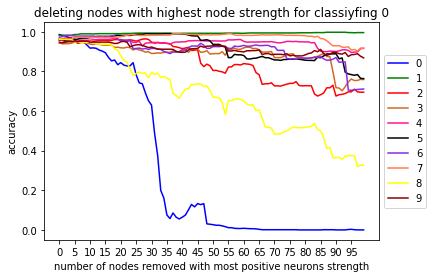

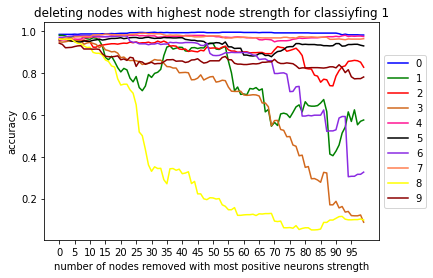

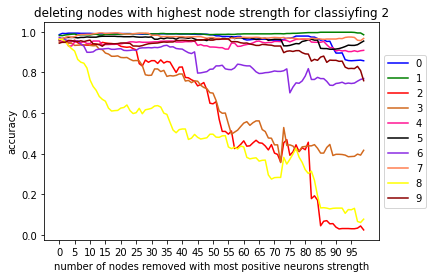

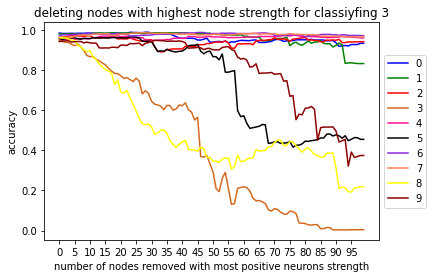

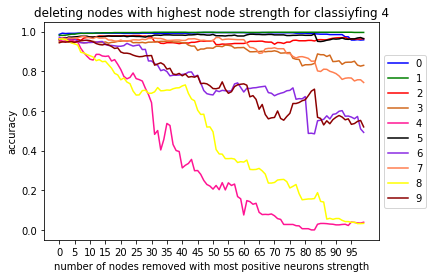

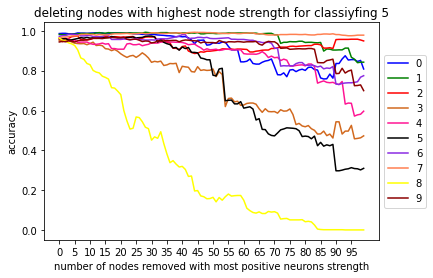

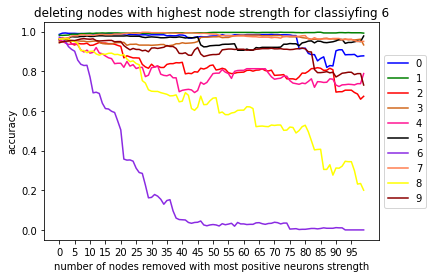

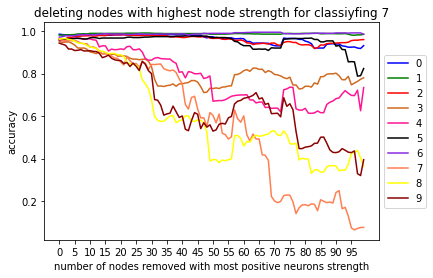

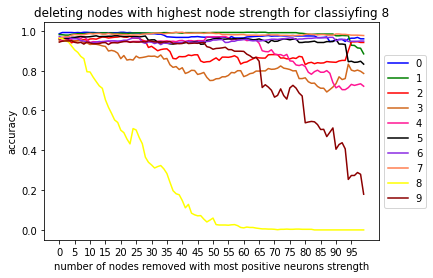

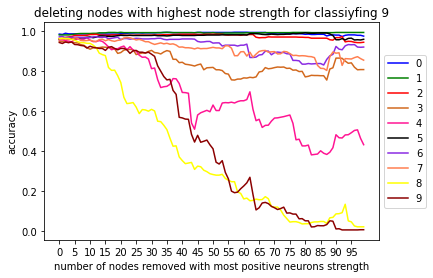

In [ ]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
col = ["b", "g", "r", "chocolate", "deeppink", "black", "blueviolet", "coral", "yellow", "darkred"]
legend = range(10)
# plot correlation of accuracy for deleting 100 nodes consecutively

for z in range(len(accu)):
    # counter needed for color
    i=0
    for ix in range(10):
        nodes = list(sorted_count[z].keys())[:99]
        new_nodes = []
        for node in nodes:
            new_nodes.append(str(node))
        new_nodes.insert(0,"none")
        number_acc = []
        for n in range(len(accu[z])):
            number_acc.append(accu[z][n][ix])
        c = col[i]
        if i < 9:
            i += 1
        plt.plot(new_nodes, number_acc , color = colors[c])
        
    
    plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(ticks=new_nodes[0::5], labels = l)
    plt.xlabel("number of nodes removed with most positive neurons strength")
    plt.ylabel("accuracy")
    plt.title(f'deleting nodes with highest node strength for classiyfing {z}')
    plt.show()


# Correlation Accuracy-Neuron strength based sum of neuron strength

In [ ]:
correct_pos_ns_allnum = []
wrong_pos_ns_allnum = []
# iterate through the numbers 0-10 and find out the number
# each input image is classified 
for number in range(10):
    allnumber = []
    for e in testset:
        if e[-1] == number:
            allnumber.append(e[0])
    allnumber2 = torch.Tensor(len(allnumber),28,28)
    allnumber = torch.cat(allnumber,out=allnumber2)
    with torch.no_grad():
        kk = net(allnumber.view(-1,28*28))

  # check which images classified correctly or incorrectly and save it for each number
    correctind = []
    wrongind = []
    for i,e in enumerate(kk):
        if torch.argmax(e) == number:
            correctind.append(i)
        else:
            wrongind.append(i)


    correctindtensor = torch.tensor(correctind,dtype=torch.long)
    wrongindtensor = torch.tensor(wrongind,dtype=torch.long)

    scaled_fc1data = torch.Tensor(len(net.fc1data),net.fc1data.size(dim=1))
    for i,e in enumerate(net.fc1data):
        for j,u in enumerate(e):
            scaled_fc1data[i][j] = u

    # for each number node data is saved in tensor for correct and incorrect classification
    fc1data_correct = scaled_fc1data[correctindtensor]
    fc1data_wrong = scaled_fc1data[wrongindtensor]
    
    # for each number a dictionary of all nodes in the hidden layer (200), with the neurons strength
    # is saved. 
    correct_pos_ns = {node_num: [] for node_num in range(200)}
    
    for corr_image_num in correctindtensor:
        for image in range(len(scaled_fc1data)):
            if corr_image_num == image:
                for i in range(len(scaled_fc1data[image])):
                    if scaled_fc1data[corr_image_num][i]>0: # positive node strength
                        correct_pos_ns[i].append(scaled_fc1data[image][i])
                        
    wrong_pos_ns = {node_num: [] for node_num in range(200)}
    for wrong_image_num in wrongindtensor:
        for image in range(len(scaled_fc1data)):
            if wrong_image_num == image:
                for i in range(len(scaled_fc1data[image])):
                    if scaled_fc1data[wrong_image_num][i]>0: # positive node strength
                        wrong_pos_ns[i].append(scaled_fc1data[image][i])

    # delete nodes negative node strength

    for key in list(correct_pos_ns.keys()):
        if correct_pos_ns[key] ==[]:
            del correct_pos_ns[key]

    for key in list(wrong_pos_ns.keys()):
        if wrong_pos_ns[key] ==[]:
            del wrong_pos_ns[key]
        

    # pos_ns_allnum is a list of 10 dictionaries, where each dictionary has all 
    # positive neurons strengths for each node in the hidden layer
    correct_pos_ns_allnum.append(correct_pos_ns)
    wrong_pos_ns_allnum.append(wrong_pos_ns)

In [ ]:
sum_ns = []
for number in correct_pos_ns_allnum:
    s = {}
    for key,value in number.items():
        s[key] = sum(value)
    sum_ns.append(s)

In [ ]:
sorted_sum_count = []
for number in sum_ns:
    x = {k: v for k, v in sorted(number.items(), key=lambda item: item[1], reverse = True)}
    sorted_sum_count.append(x)

In [ ]:
accu_sum=[]
# iterate though the first 100 sorted_count neurons. 
# These are the neurons that are activated most when an input is classified 
# by the network
for ix in range(len(sorted_sum_count)):
    print(ix)
    nodes = list(sorted_sum_count[ix].keys())[:100]
    accuracies= []

    name = range(len(nodes))
    # load model
    PATH = "NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_final.pth"
    net.load_state_dict(torch.load(PATH))
    # dictionary to save correct classified and all classified 
    for n in range(len(nodes)):
        correct ={classname: 0 for classname in classes}
        total = {classname: 0 for classname in classes}

        with torch.no_grad():
            for i, data in enumerate(testloader,0):
                inputs, labels = data
                outputs = net(inputs.view(-1,28*28))
                _, predictions = torch.max(outputs,1)
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct[classes[label]] +=1
                    total[classes[label]]+=1
            acc = []
            for i in range(10):
                acc.append(correct[str(i)]/total[str(i)])
            accuracies.append(acc)
        # deactivate neurons
        net.fc2.weight.data[:,nodes[n]] = 0
        # rescaling the bias in fc2
        net.fc2.bias.data *= 199/200
        # save model 
        PATH = f'NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_del_sum_{ix}_{name[n]}.pth'
        torch.save(net.state_dict(), PATH)
    
    accu_sum.append(accuracies)

0
1
2
3
4
5
6
7
8
9


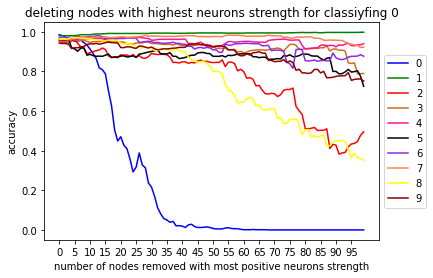

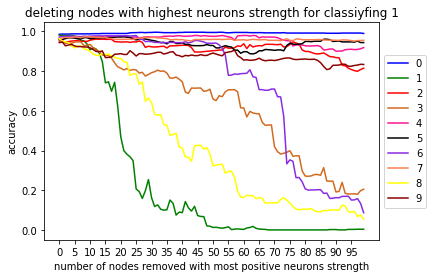

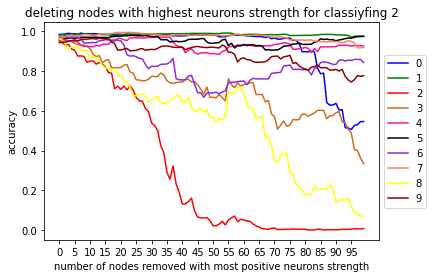

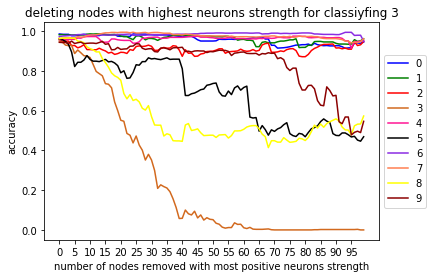

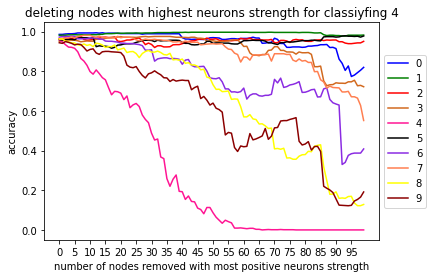

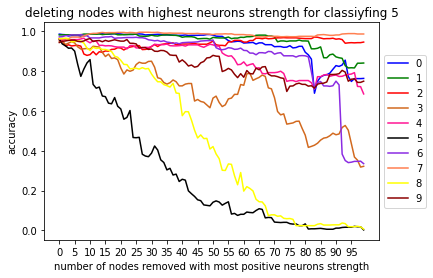

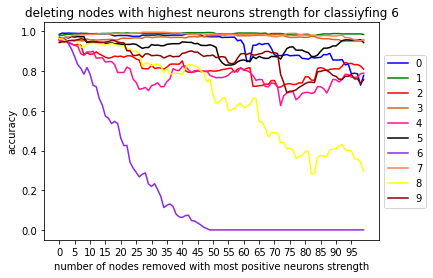

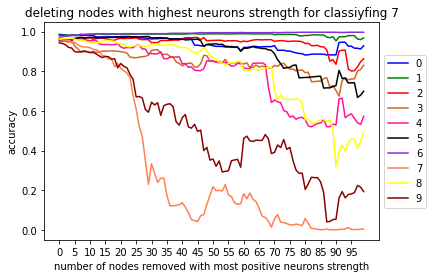

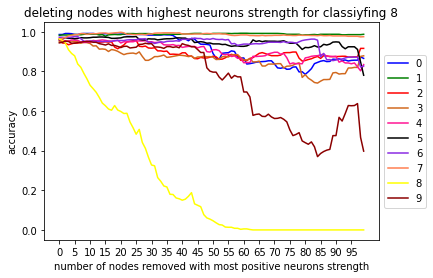

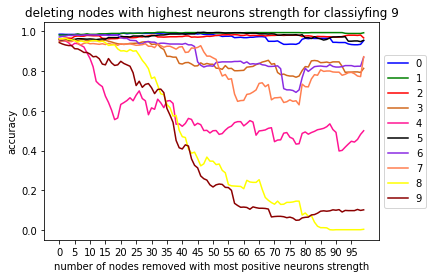

In [ ]:
# plot correlation of accuracy for deleting 100 nodes consecutively
for z in range(len(accu_sum)):
   # counter needed for color
    i=0
    for ix in range(10):
        nodes = list(sorted_sum_count[z].keys())[:99]
        new_nodes = []
        for node in nodes:
            new_nodes.append(str(node))
        new_nodes.insert(0,"none")
        number_acc = []
        for n in range(len(accu_sum[z])):
            number_acc.append(accu_sum[z][n][ix])
        c = col[i]
        if i < 9:
            i += 1
        plt.plot(new_nodes, number_acc , color = colors[c])
        
    
    plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(ticks=new_nodes[0::5], labels = l)
    plt.xlabel("number of nodes removed with most positive neurons strength")
    plt.ylabel("accuracy")
    plt.title(f'deleting nodes with highest neurons strength for classiyfing {z}')
    plt.show()


# Minimal Network



Here we pruned the network to increase the number of neurons in the hidden layer but still have a high accuracy


## Minimal Network based on number of activation
find all neurons that are responsible for an accuracy of more than 50%. Then delete all neurons that are not responsible and check accuracy

In [ ]:
diff_acc = [0.5,0.6,0.7,0.8,0.85,0.9,0.95]

In [ ]:
acc_total = []
acc_numbers = []
num_nodes = []
for acc in diff_acc:
    num_acc={}
    for number in range(len(accu)):
        for node in range(len(accu[number])):
            if accu[number][node][number] < acc:
                num_acc[number] = node
                break
    min_net_nodes = []
    for num in range(10):
        min_net_nodes.append(list(sorted_count[num].keys())[:num_acc[num]])
    
    u_min_net_nodes = []
    for num in min_net_nodes:
        for node in num:
            if node not in u_min_net_nodes:
                u_min_net_nodes.append(node)
    # make minimal network
    PATH = "NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_final.pth"
    net.load_state_dict(torch.load(PATH))
    # activate only nodes that are necessary
    for i in range(200):
        if i not in u_min_net_nodes:
            net.fc1.weight.data[i] = 0
            net.fc1.bias.data[i] = 0
    # save model 
    PATH = f'NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_{acc}_min.pth'
    torch.save(net.state_dict(), PATH)

    correct ={classname: 0 for classname in classes}
    total = {classname:0 for classname in classes}

    with torch.no_grad():
        for i, data in enumerate(testloader,0):
            inputs, labels = data
            outputs = net(inputs.view(-1,28*28))
            _, predictions = torch.max(outputs,1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct[classes[label]] +=1
                total[classes[label]]+=1
    # total accuracy
    acc_tot = 0
    for n in range(10):
        acc_tot += correct[str(n)]/total[str(n)]
    acc_total.append(acc_tot/10)
    num_nodes.append(str(len(u_min_net_nodes)))
    print(f'The overall accuracy is {acc_tot/10}. The network contains {len(u_min_net_nodes)} nodes.')
    accs = []
    for classname, cor in correct.items():
        accuracy = cor/total[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:f}')  
        accs.append(accuracy)
    acc_numbers.append(accs)
    

The overall accuracy is 0.9465609951678202. The network contains 156 nodes.
Accuracy for class: 0     is 0.957143
Accuracy for class: 1     is 0.964758
Accuracy for class: 2     is 0.964147
Accuracy for class: 3     is 0.954455
Accuracy for class: 4     is 0.960285
Accuracy for class: 5     is 0.856502
Accuracy for class: 6     is 0.967641
Accuracy for class: 7     is 0.945525
Accuracy for class: 8     is 0.977413
Accuracy for class: 9     is 0.917740
The overall accuracy is 0.9414603532652752. The network contains 147 nodes.
Accuracy for class: 0     is 0.959184
Accuracy for class: 1     is 0.966520
Accuracy for class: 2     is 0.956395
Accuracy for class: 3     is 0.954455
Accuracy for class: 4     is 0.950102
Accuracy for class: 5     is 0.841928
Accuracy for class: 6     is 0.966597
Accuracy for class: 7     is 0.920233
Accuracy for class: 8     is 0.979466
Accuracy for class: 9     is 0.919722
The overall accuracy is 0.9215113188723991. The network contains 126 nodes.
Accuracy for

In [ ]:
# get accuracies for each number. Formatting for the plotting
acc_nums = []
for u in range(10):
    acc= []
    for i in range(len(acc_numbers)):
        acc.append(acc_numbers[i][u])
    acc_nums.append(acc)

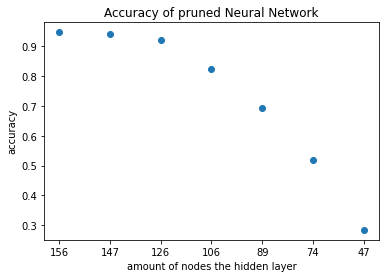

In [ ]:
# plot overall accuracy vs number nodes
plt.scatter(num_nodes,acc_total)
plt.title(f'Accuracy of pruned Neural Network')
plt.xlabel(f'amount of nodes the hidden layer')
plt.ylabel(f'accuracy')
plt.show()

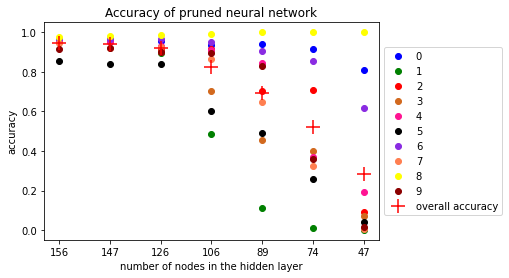

In [ ]:
# plot the accuracy for classifying all numbers with a specific 
# amount of nodes which are needed for a certain accuracy. 
i = 0
for a in acc_nums:
    ys = np.array(a)
    c = col[i]
    plt.scatter(num_nodes, ys, color = colors[c])
    i +=1

    
legend_1 = list(map(str, legend))
legend_1.append("overall accuracy")
# add overall accuracy to plot
plt.scatter(num_nodes,acc_total, marker = "+", s = 200, color = "red")   
plt.legend(legend_1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("number of nodes in the hidden layer")
plt.ylabel("accuracy")
plt.title(f'Accuracy of pruned neural network')
plt.show()


## Minimal Network based on sum of neurons strength
We check the accurcies for different amounts of nodes in the second layer based on different accuracies as cut-off value.
 


In [ ]:
diff_acc_sum = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85,0.9,0.95]

In [ ]:
acc_total_sum = []
acc_numbers_sum = []
num_nodes_sum = []
for acc in diff_acc_sum:
    num_acc_sum={}
    for number in range(len(accu_sum)):
        for node in range(len(accu_sum[number])):
            if accu_sum[number][node][number] < acc:
                num_acc_sum[number] = node
                break
    min_net_nodes_sum = []
    for num in range(10):
        min_net_nodes_sum.append(list(sorted_sum_count[num].keys())[:num_acc_sum[num]])
    
    u_min_net_nodes = []
    for num in min_net_nodes_sum:
        for node in num:
            if node not in u_min_net_nodes:
                u_min_net_nodes.append(node)
    # make minimal network
    PATH = "NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_final.pth"
    net.load_state_dict(torch.load(PATH))
    # activate only nodes that are necessary
    for i in range(200):
        if i not in u_min_net_nodes:
            net.fc1.weight.data[i] = 0
            net.fc1.bias.data[i] = 0
    # save model 
    PATH = f'NetworkProject/Notebook3Data/NeuronStrengthAnalysis/net_{acc}_min_sum.pth'
    torch.save(net.state_dict(), PATH)

    correct ={classname: 0 for classname in classes}
    total = {classname:0 for classname in classes}

    with torch.no_grad():
        for i, data in enumerate(testloader,0):
            inputs, labels = data
            outputs = net(inputs.view(-1,28*28))
            _, predictions = torch.max(outputs,1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct[classes[label]] +=1
                total[classes[label]]+=1
    # total accuracy
    acc_tot = 0
    for n in range(10):
        acc_tot += correct[str(n)]/total[str(n)]
    acc_total_sum.append(acc_tot/10)
    num_nodes_sum.append(str(len(u_min_net_nodes)))
    print(f'The overall accuracy is {acc_tot/10}. The network contains {len(u_min_net_nodes)} nodes.')
    accs = []
    for classname, cor in correct.items():
        accuracy = cor/total[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:f}')  
        accs.append(accuracy)
    acc_numbers_sum.append(accs)
    

The overall accuracy is 0.957126566556496. The network contains 150 nodes.
Accuracy for class: 0     is 0.982653
Accuracy for class: 1     is 0.962996
Accuracy for class: 2     is 0.952519
Accuracy for class: 3     is 0.938614
Accuracy for class: 4     is 0.932790
Accuracy for class: 5     is 0.951794
Accuracy for class: 6     is 0.974948
Accuracy for class: 7     is 0.954280
Accuracy for class: 8     is 0.970226
Accuracy for class: 9     is 0.950446
The overall accuracy is 0.9553813917889732. The network contains 137 nodes.
Accuracy for class: 0     is 0.983673
Accuracy for class: 1     is 0.970044
Accuracy for class: 2     is 0.960271
Accuracy for class: 3     is 0.921782
Accuracy for class: 4     is 0.916497
Accuracy for class: 5     is 0.950673
Accuracy for class: 6     is 0.977035
Accuracy for class: 7     is 0.951362
Accuracy for class: 8     is 0.965092
Accuracy for class: 9     is 0.957384
The overall accuracy is 0.9518152624648073. The network contains 122 nodes.
Accuracy for 

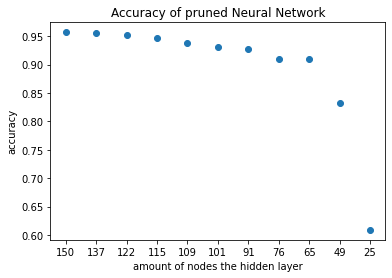

In [ ]:
# plot overall accuracy vs number nodes
plt.scatter(num_nodes_sum,acc_total_sum)
plt.title(f'Accuracy of pruned Neural Network')
plt.xlabel(f'amount of nodes the hidden layer')
plt.ylabel(f'accuracy')
plt.show()

In [ ]:
# get accuracies for each number. Formatting for the plotting
acc_nums_sum = []
for u in range(10):
    acc= []
    for i in range(len(acc_numbers_sum)):
        acc.append(acc_numbers_sum[i][u])
    acc_nums_sum.append(acc)

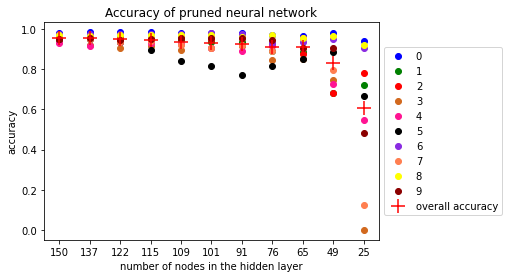

In [ ]:
# plot the accuracy for classifying all numbers with a specific 
# amount of nodes which are needed for a certain accuracy. 
i = 0
for a in acc_nums_sum:
    ys = np.array(a)
    c = col[i]
    plt.scatter(num_nodes_sum, ys, color = colors[c])
    i +=1

    
legend_1 = list(map(str, legend))
legend_1.append("overall accuracy")
# add overall accuracy to plot
plt.scatter(num_nodes_sum,acc_total_sum, marker = "+", s = 200, color = "red")   
plt.legend(legend_1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("number of nodes in the hidden layer")
plt.ylabel("accuracy")
plt.title(f'Accuracy of pruned neural network')
plt.show()


End Catalina

# Change in accuracy from removing nodes





Here, we check if there is a correlation between accuracy and node strength by removing nodes and evaluating the accuracy.

By Simon Godskesen

In [ ]:
#find accuracy
def evaluate_model(network):
  correct = 0
  total = 0
  with torch.no_grad():
    for i, data in enumerate(testloader,0):
      inputs, labels = data
      outputs = network(inputs.view(-1,28*28))
      for i,e in enumerate(outputs):
        if torch.argmax(e) == labels[i]:
          correct += 1
        total += 1
  return correct/total

#finds the node strength of each node in the first layer
def get_node_strength(network):
  using_bias = network.fc1.bias != None
  if using_bias:
    bias_data = network.fc1.bias

  weight_data = network.fc1.weight.data  
  next_weight_data = network.fc2.weight.data  
  num_nodes = weight_data.size(dim=0) #number of nodes in that layer
  node_strength_layer_one = np.zeros(num_nodes)  #empty numpy list

  for i in range(num_nodes): #for each node
    node_strength_layer_one[i] += sum(weight_data[i,:]) #find incoming weights
    if using_bias:
      node_strength_layer_one[i] += bias_data[i]*weight_data.size(dim=1)
    node_strength_layer_one[i] += sum(next_weight_data[:,i])
  return node_strength_layer_one

In [ ]:


By#Accuracy change from removing a single node
accuracy_deact_node = []
zipped = zip(range(len(net.fc1.weight)),get_node_strength(net))
zipped = sorted(zipped,key=lambda x: x[1])
real_accuracy = evaluate_model(net)

for e in zipped:
  net.load_state_dict(torch.load("NetworkProject/Notebook3Data/NodeStrengthRemoval/175908"))
  with torch.no_grad():
    net.fc2.weight[:,e[0]] = 0
    net.fc2.bias *= (len(net.fc1.weight)-1)/len(net.fc1.weight)
  accuracy_deact_node.append(list(e)+[evaluate_model(net)])

In [ ]:
improvements = [e for e in accuracy_deact_node if e[2]>real_accuracy]
print(f"Number of improvements: {len(improvements)}")
plt.figure(figsize = (10,8))
plt.plot([e[1] for e in accuracy_deact_node],[e[2] for e in accuracy_deact_node],'ro',[e[1] for e in accuracy_deact_node],[real_accuracy]*len(accuracy_deact_node),'g')
plt.xlabel('Node strength')
plt.ylabel('Change in accuracy')
plt.title('Accuracy when deactivating a single node with x node strength\nin network with 200 nodes')
plt.legend(["Accuracy after node deactivation",f"Accuracy without node deactivation = {real_accuracy}"])
#plt.savefig("drive/MyDrive/NetworkProject/catalinas200net_node_single_removal")
plt.show()